notebook_006_orbitpropa_iss_vis_mauritius

# ISS visibility from Mauritius in the evening of 25 August 2017

Pretty much the same thing as notebook_005_orbitpropa_sgp4_local_topo_visualization.ipynb, except that the observer is in Vacoas, Mauritius (my home town).

@author: Ashiv Dhondea

created on: 25.08.17

In [1]:
# Load the libraries required
# These two are mine
import AstroFunctions as AstFn
import UnbiasedConvertedMeasurements as UCM

import math
import numpy as np

# Libraries needed for time keeping and formatting
import datetime as dt
import pytz

# Importing what's needed for nice plots.
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# Module for SGP4 orbit propagation
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv

In [2]:
"""
http://heavens-above.com/PassSummary.aspx?satid=25544&lat=-20.2973&lng=57.4967&loc=Vacoas-Phoenix&alt=431&tz=UCTm4

Vacoas-Phoenix
(20.2973°S, 57.4967°E)
"""

# Location of observer [Vacoas-Phoenix, MU]
lat_station = -20.2973; # [deg]
lon_station =  57.4967; # [deg]
altitude_station = 419.e-3; # [km]

In [3]:
## ISS (ZARYA)                        
tle_line1 = '1 25544U 98067A   17237.22055556  .00001903  00000-0  35918-4 0  9993';
tle_line2 = '2 25544  51.6395  54.1832 0005056 175.7910 168.4891 15.54196720 72488';
so_name = 'ISS (ZARYA)'
# Read TLE to extract Keplerians and epoch. 
a,e,i,BigOmega,omega,E,nu,epoch  = AstFn.fnTLEtoKeps(tle_line1,tle_line2);

# Create satellite object
satellite_obj = twoline2rv(tle_line1, tle_line2, wgs84);

line1 = (tle_line1);
line2 = (tle_line2);

In [4]:
# Figure out the TLE epoch 
year,dayy, hrs, mins, secs, millisecs = AstFn.fn_Calculate_Epoch_Time(epoch);
todays_date = AstFn.fn_epoch_date(year,dayy);
print "TLE epoch date is", todays_date
print "UTC time = ",hrs,"h",mins,"min",secs+millisecs,"s"
timestamp_tle_epoch = dt.datetime(year=todays_date.year,month=todays_date.month,day=todays_date.day,hour=hrs,minute=mins,second=secs,microsecond=int(millisecs),tzinfo= pytz.utc);


TLE epoch date is 2017-08-25
UTC time =  5 h 17 min 36.000384 s


According to heavens-above.com, the ISS will be visible in Mauritius from 19:31:04 to 19:34:21 (local time).

The local time (MUT) is 4 hours ahead of UTC.
So the observation epoch is 15:31:04 to 15:34:21

In [5]:
# Find start and end of observation window.
# Find the time elapsed between the epoch of the TLE and the start and end of the observation window
observation_epoch= dt.datetime(year=todays_date.year,month=todays_date.month,day=25,hour=15,minute=34,second=21,microsecond=0,tzinfo= pytz.utc);
simulation_duration_dt_obj = observation_epoch - timestamp_tle_epoch;
simulation_duration_secs = simulation_duration_dt_obj.total_seconds();

start_observation_epoch = dt.datetime(year=todays_date.year,month=todays_date.month,day=25,hour=15,minute=31,second=4,microsecond=0,tzinfo= pytz.utc)
start_simulation_duration_dt_obj = start_observation_epoch - timestamp_tle_epoch;
start_simulation_duration_secs = start_simulation_duration_dt_obj.total_seconds()

In [6]:
# Declare time and state vector variables.
delta_t = 1; #[s]
print 'Propagation time step = %d' %delta_t, '[s]'
duration = simulation_duration_secs; #[s]
print 'Duration of simulation = %d' %duration, '[s]'
timevec = np.arange(0,duration+delta_t,delta_t,dtype=np.float64);
x_state_sgp4 = np.zeros([6,len(timevec)],dtype=np.float64);
xecef_sgp4 = np.zeros([3,len(timevec)],dtype=np.float64);
# Declare variables to store latitude and longitude values of the ground track
lat_sgp4 = np.zeros([len(timevec)],dtype=np.float64);
lon_sgp4 = np.zeros([len(timevec)],dtype=np.float64);

Propagation time step = 1 [s]
Duration of simulation = 37005 [s]


In [7]:
# Identify the indices corresponding to start and end of the observation window
obsv_window_start_index = int(start_simulation_duration_secs/delta_t)
obsv_window_end_index = len(timevec) - 1;
print 'observation window starts at index '
print obsv_window_start_index
print 'and ends at '
print obsv_window_end_index
obsv_window_duration = (obsv_window_end_index - obsv_window_start_index);# should be int, not float
print 'Duration of observation window in [min]'
print obsv_window_duration*delta_t/60
obsv_window_timestamps = [None]*(obsv_window_duration+1); # Initialize empty list to hold time stamps
print 'Number of data points in observation window: '
print len(obsv_window_timestamps)

observation window starts at index 
36808
and ends at 
37005
Duration of observation window in [min]
3
Number of data points in observation window: 
198


In [8]:
R_SEZ = np.zeros([3,len(timevec)],dtype=np.float64);
V_SEZ = np.zeros([3,len(timevec)],dtype=np.float64);
x_target = np.zeros([6,len(timevec)],dtype=np.float64); 
#  spherical measurements from the Rx
y_sph_rx = np.zeros([3,len(timevec)],dtype=np.float64);
theta_GMST = np.zeros([len(timevec)],dtype=np.float64); 

index = 0;
current_time = timevec[index];
hrs,mins,secs = AstFn.fnSeconds_To_Hours(current_time + (satellite_obj.epoch.hour*60*60) + (satellite_obj.epoch.minute*60)+ satellite_obj.epoch.second);
dys = satellite_obj.epoch.day + int(math.ceil(hrs/24));     
if hrs >= 24:
    hrs = hrs - 24*int(math.ceil(hrs/24)) ;
satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
x_state_sgp4[0:3,index] = np.asarray(satpos);
x_state_sgp4[3:6,index] = np.asarray(satvel);

theta_GMST[0] =  math.radians(AstFn.fn_Convert_Datetime_to_GMST(timestamp_tle_epoch));        
# Rotate ECI position vector by GMST angle to get ECEF position
theta_GMST[0] = AstFn.fnZeroTo2Pi(theta_GMST[0]);
xecef_sgp4[:,index] = AstFn.fnECItoECEF(x_state_sgp4[0:3,index],theta_GMST[index]);
lat_sgp4[index],lon_sgp4[index] = AstFn.fnCarts_to_LatLon(xecef_sgp4[:,index]);

for index in range(1,len(timevec)):
    # Find the current time
    current_time = timevec[index];
    hrs,mins,secs = AstFn.fnSeconds_To_Hours(current_time + (timestamp_tle_epoch.hour*60*60) + (timestamp_tle_epoch.minute*60)+ timestamp_tle_epoch.second);
    dys = timestamp_tle_epoch.day + int(math.ceil(hrs/24)); 
    if hrs >= 24:
        hrs = hrs - 24*int(math.ceil(hrs/24)) ;
        
    # SGP4 propagation
    satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
    x_state_sgp4[0:3,index] = np.asarray(satpos);
    x_state_sgp4[3:6,index] = np.asarray(satvel);
    
    # From the epoch, find the GMST angle.
    tle_epoch_test = dt.datetime(year=timestamp_tle_epoch.year,month=timestamp_tle_epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
    theta_GMST[index] =  math.radians(AstFn.fn_Convert_Datetime_to_GMST(tle_epoch_test));        
    # Rotate ECI position vector by GMST angle to get ECEF position
    theta_GMST[index] = AstFn.fnZeroTo2Pi(theta_GMST[index]);
    xecef_sgp4[:,index] = AstFn.fnECItoECEF(x_state_sgp4[0:3,index],theta_GMST[index]);
    lat_sgp4[index],lon_sgp4[index] = AstFn.fnCarts_to_LatLon(xecef_sgp4[:,index]);
    if index >= obsv_window_start_index:
        # We store away timestamps for the observation window
        current_time_iso = tle_epoch_test.isoformat() + 'Z'
        obsv_window_timestamps[index-obsv_window_start_index] =current_time_iso;
        
        # We find the position and velocity vector for the target in the local frame.
        # We then create the measurement vector consisting of range and look angles to the target.
        R_ECI = x_state_sgp4[0:3,index]; V_ECI = x_state_sgp4[3:6,index];  
        R_SEZ[:,index] = AstFn.fnRAZEL_Cartesian(math.radians(lat_station),math.radians(lon_station),altitude_station,R_ECI,theta_GMST[index]); 
        R_ECEF = AstFn.fnECItoECEF(R_ECI,theta_GMST[index]);
        V_SEZ[:,index] = AstFn.fnVel_ECI_to_SEZ(V_ECI,R_ECEF,math.radians(lat_station),math.radians(lon_station),theta_GMST[index]);
        x_target[:,index] = np.hstack((R_SEZ[:,index],V_SEZ[:,index])); # state vector in SEZ frame
        # Calculate range and angles for system modelling.
        y_sph_rx[:,index] = UCM.fnCalculate_Spherical(R_SEZ[:,index]); # slant-range and look angles wrt to Rx

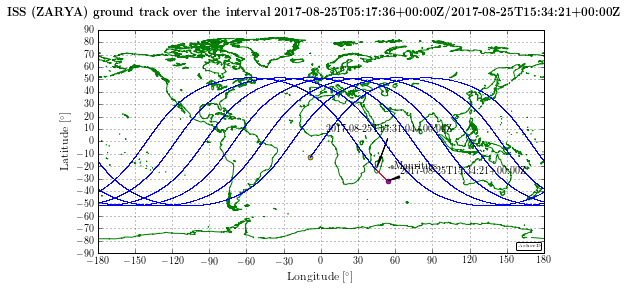

In [9]:
%matplotlib inline

title_string = str(timestamp_tle_epoch.isoformat())+ 'Z/'+str(obsv_window_timestamps[-1]);

coastline_data= np.loadtxt('Coastline.txt',skiprows=1)
w, h = plt.figaspect(0.5)
fig = plt.figure(figsize=(w,h))
ax = fig.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
params = {'legend.fontsize': 8,
    'legend.handlelength': 2}
plt.rcParams.update(params)

fig.suptitle(r"\textbf{%s ground track over the interval %s}" %(so_name,title_string),fontsize=12)
plt.plot(coastline_data[:,0],coastline_data[:,1],'g');
ax.set_xlabel(r'Longitude $[\mathrm{^\circ}]$',fontsize=12)
ax.set_ylabel(r'Latitude $[\mathrm{^\circ}]$',fontsize=12)
plt.xlim(-180,180);
plt.ylim(-90,90);
plt.yticks([-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90]);
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]);
plt.plot(math.degrees(lon_sgp4[0]),math.degrees(lat_sgp4[0]),'yo',markersize=5,label=timestamp_tle_epoch.isoformat() + 'Z');
for index in range(1,obsv_window_start_index-1):
    plt.plot(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index]),'b.',markersize=1);

plt.annotate(r'%s' %obsv_window_timestamps[0], xy=(math.degrees(lon_sgp4[index+1]),math.degrees(lat_sgp4[index+1])),  xycoords='data',
            xytext=(math.degrees(lon_sgp4[index+1])-40,math.degrees(lat_sgp4[index+1])+30),
            arrowprops=dict(facecolor='black',shrink=0.05,width=0.1,headwidth=2))

for index in range(obsv_window_start_index,obsv_window_end_index+1):
    plt.plot(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index]),color='crimson',marker='.',markersize=1);

plt.plot(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index]),'mo',markersize=5,label=current_time_iso);

plt.annotate(r'%s' %obsv_window_timestamps[obsv_window_duration], xy=(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index])),  xycoords='data',
            xytext=(math.degrees(lon_sgp4[index])+10,math.degrees(lat_sgp4[index])+5),
            arrowprops=dict(facecolor='black', shrink=0.05,width=0.1,headwidth=2)
            )

ax.grid(True);
plt.plot(lon_station,lat_station,marker='.',color='gray'); # station lat lon
ax.annotate(r'Mauritius', (59, -23));

at = AnchoredText("AshivD",prop=dict(size=5), frameon=True,loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
fig.savefig('notebook_006_orbitpropa_iss_vis_mauritius_groundtrack.pdf',format='pdf',bbox_inches='tight',pad_inches=0.01,dpi=100);

In the ground track plot shown above, we note that the visible part of the ISS's trajectory is in red. Mauritius has been labelled. Take a look at the saved plot 'notebook_006_orbitpropa_iss_vis_mauritius_groundtrack.pdf' if the plot above does not appear clearly on your browser.

It is readily seen that the ISS will appear in the sky in the West-South-West of Mauritius and disappear in the South-South-West.

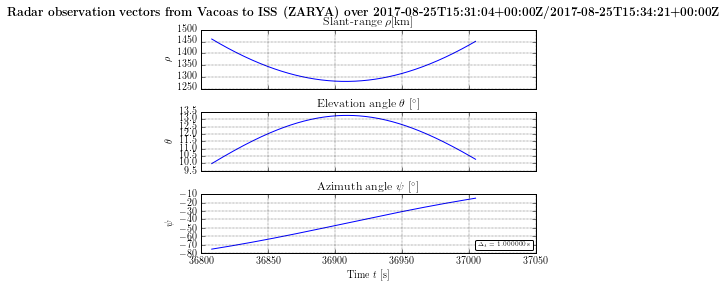

In [10]:
title_string_obsv = str(obsv_window_timestamps[0])+'/'+str(obsv_window_timestamps[-1]);

f, axarr = plt.subplots(3,sharex=True);
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
f.suptitle(r"\textbf{Radar observation vectors from Vacoas to %s over %s}" %(so_name,title_string_obsv),fontsize=12)
axarr[0].plot(timevec[obsv_window_start_index:obsv_window_end_index+1],y_sph_rx[0,obsv_window_start_index:obsv_window_end_index+1])
axarr[0].set_ylabel(r'$\rho$');
axarr[0].set_title(r'Slant-range $\rho [\mathrm{km}]$')
axarr[1].plot(timevec[obsv_window_start_index:obsv_window_end_index+1],np.degrees(y_sph_rx[1,obsv_window_start_index:obsv_window_end_index+1]))
axarr[1].set_title(r'Elevation angle $\theta~[\mathrm{^\circ}]$')
axarr[1].set_ylabel(r'$\theta$');

axarr[2].plot(timevec[obsv_window_start_index:obsv_window_end_index+1],np.degrees(y_sph_rx[2,obsv_window_start_index:obsv_window_end_index+1]))
axarr[2].set_title(r'Azimuth angle $\psi~[\mathrm{^\circ}]$')
axarr[2].set_ylabel(r'$ \psi$');
axarr[2].set_xlabel(r'Time $t~[\mathrm{s}$]');

axarr[0].grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')
axarr[1].grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')
axarr[2].grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')

at = AnchoredText(r"$\Delta_t = %f ~\mathrm{s}$" %delta_t,prop=dict(size=6), frameon=True,loc=4)
at.patch.set_boxstyle("round,pad=0.05,rounding_size=0.2")
axarr[2].add_artist(at)
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0:2]], visible=False)
plt.subplots_adjust(hspace=0.4)
f.savefig('notebook_006_orbitpropa_iss_vis_mauritius_radarvec.pdf',bbox_inches='tight',pad_inches=0.05,dpi=100)  


The top plot shows the evolution of the slant-range to the target, $\rho$, over time. The middle plot shows that the elevation angle is about $10^\circ$ above the horizon at the beginning of the observation window. The target disappears at about $10^\circ$ above the horizon at the end of the observation window.

The target's azimuth angle changes from about $-75^\circ$ to $-15^\circ$.

The elevation angle values closely match the ones found on the [heavens-above page](http://heavens-above.com/PassSummary.aspx?satidat =25544&lat=-20.2973&lng=57.4967&loc=Vacoas-Phoenix&alt=431&tz=UCTm4).

According to the azimuth angle defined in the previous figures, WSW means an azimuth angle of $-67.5^\circ$ & SSW means $-22.5^\circ$. Our values are slightly different (but in the same ballpark). Obviously, the Heavens-Above page is mainly intended for laypeople and as such, does not state the azimuth direction accurately.

Here's a screenshot

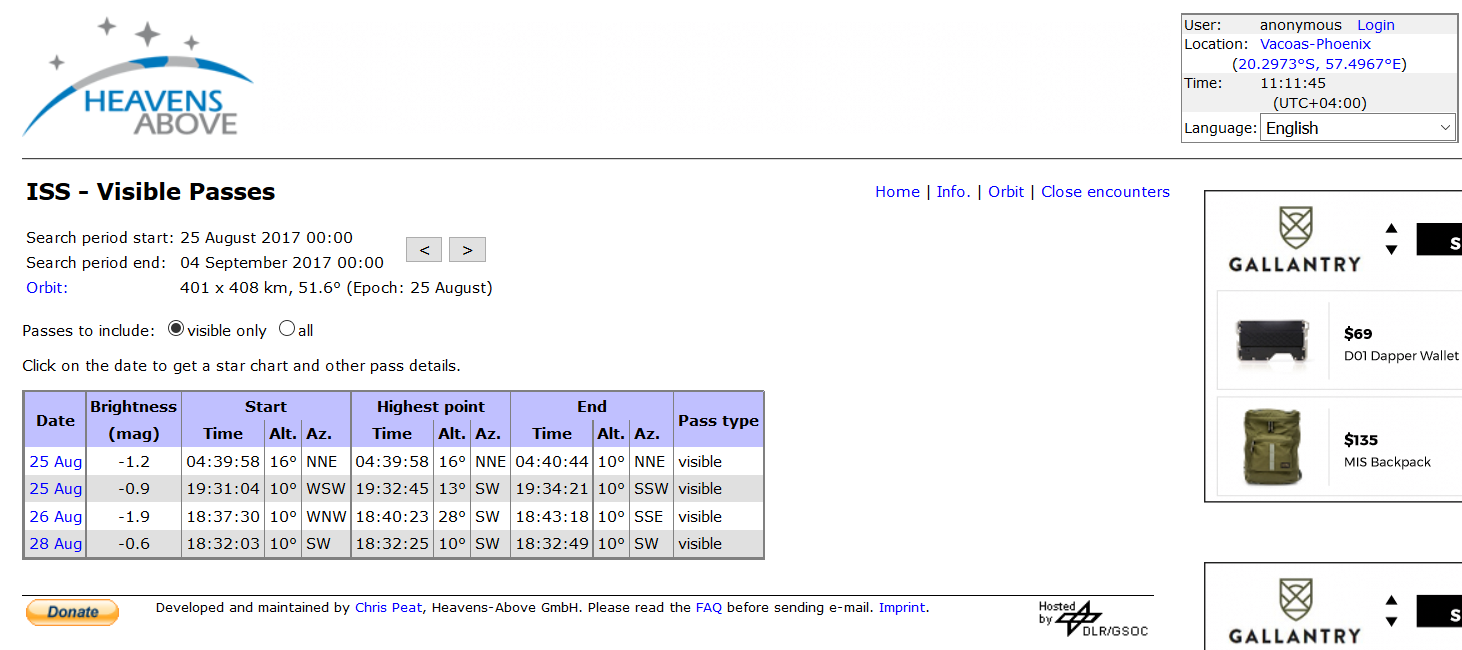

In [11]:
from IPython.display import Image
Image(filename='heavens_above_iss_passage_mru.png')

In [12]:
## right ascension and declination to target
ra = np.zeros([len(timevec)],dtype=np.float64);
dec = np.zeros([len(timevec)],dtype=np.float64);

for index in range(obsv_window_start_index,obsv_window_end_index+1):
    valladoazim = math.pi - y_sph_rx[2,index];
    RA, DEC = AstFn.fnConvert_AZEL_to_Topo_RADEC(y_sph_rx[1,index],valladoazim,math.radians(lat_station),math.radians(lon_station),theta_GMST[index]);
    ra[index] =  math.degrees(RA);
    dec[index] =  math.degrees(DEC);

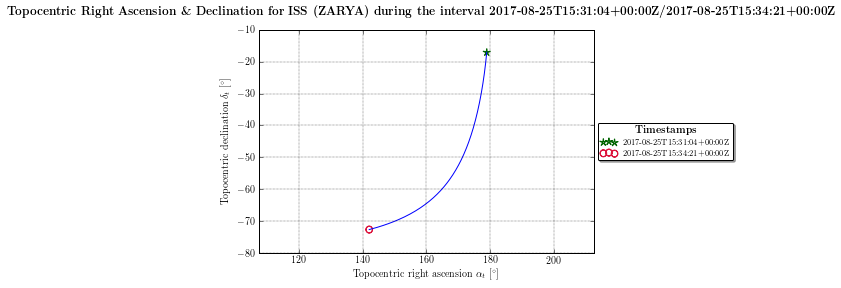

In [13]:
fig = plt.figure(4);
ax = fig.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.axis('equal')
fig.suptitle(r"\textbf{Topocentric Right Ascension \& Declination for %s during the interval %s}" %(so_name,title_string_obsv) ,fontsize=12);
plt.plot(ra[obsv_window_start_index:obsv_window_end_index+1],dec[obsv_window_start_index:obsv_window_end_index+1],color='blue');

plt.scatter(ra[obsv_window_start_index],dec[obsv_window_start_index],s=50,marker=r"$\star$",facecolors='none', edgecolors='darkgreen',label=r"%s" %str(obsv_window_timestamps[0]));
plt.scatter(ra[obsv_window_end_index],dec[obsv_window_end_index],s=50,marker=r"$\bigcirc$",facecolors='none',edgecolors='crimson',label=r"%s" %str(obsv_window_timestamps[-1]));

ax.set_xlabel(r'Topocentric right ascension $\alpha_{t}~[\mathrm{^\circ}]$')
ax.set_ylabel(r'Topocentric declination $ \delta_{t}~[\mathrm{^\circ}]$');

plt.legend(loc='center left',title=r"\textbf{Timestamps}",bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True)

plt.grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')
fig.savefig('notebook_006_orbitpropa_iss_vis_mauritius_radec.pdf',bbox_inches='tight',pad_inches=0.11,dpi=100)

The figure above is a plot of the topocentric right ascension and declination profile of the target passage.

If you stand outside at the given location and at the given time, you will see the ISS moving along this path in the sky. 

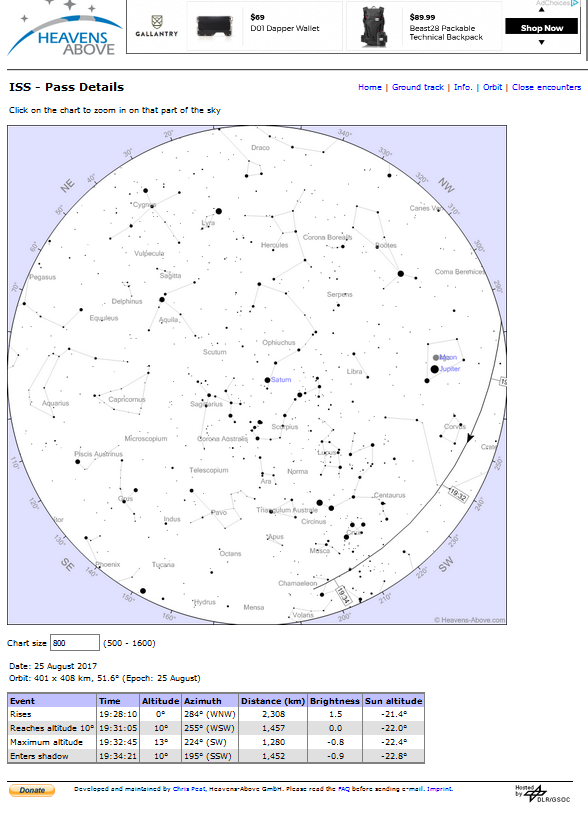

In [14]:
from IPython.display import Image
Image(filename='heavens_above_iss_passage_mru_sky.png')

This screenshot from Heavens-Above shows the sky during the ISS passage, similar to the plot we showed previously.

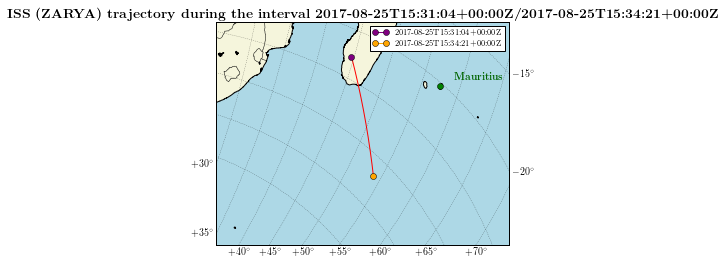

In [15]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(5);
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
map = Basemap(llcrnrlon=36.0,llcrnrlat=-50.0,urcrnrlon=64.,urcrnrlat=-12.,resolution='i', projection='cass', lat_0 = 0.0, lon_0 = 0.0)
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary(fill_color='lightblue')
map.fillcontinents(color='beige',lake_color='lightblue')
lon =np.rad2deg(lon_sgp4);
lat = np.rad2deg(lat_sgp4);
x,y = map(lon[obsv_window_start_index:obsv_window_end_index+1], lat[obsv_window_start_index:obsv_window_end_index+1])
map.plot(x, y, color="red", latlon=False,linewidth=1)
x,y = map(lon_station,lat_station)
map.plot(x,y,marker='o',color='green'); 

x2,y2 = map(59,-19)
plt.annotate(r"\textbf{Mauritius}", xy=(x2, y2),color='darkgreen')

parallels = np.arange(-40.,-5.,5.)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[False,True,False,False],labelstyle='+/-',linewidth=0.2)
meridians = np.arange(30.,71.,5.)
map.drawmeridians(meridians,labels=[True,False,False,True],labelstyle='+/-',linewidth=0.2)
plt.title(r'\textbf{%s trajectory during the interval %s}' %(so_name,title_string_obsv), fontsize=14)
x_start,y_start = map(lon[obsv_window_start_index],lat[obsv_window_start_index])
x_end,y_end = map(lon[obsv_window_end_index],lat[obsv_window_end_index])
map.plot(x_start,y_start,color="purple",marker='o',label=r"%s" %str(obsv_window_timestamps[0]))
map.plot(x_end,y_end,color="orange",marker='o',label=r"%s" %str(obsv_window_timestamps[-1]))
plt.legend(loc=1)
fig.savefig('notebook_006_orbitpropa_iss_vis_mauritius_map.pdf',bbox_inches='tight',pad_inches=0.05,dpi=100) 